In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.845679012345679, Loss: 0.6664767795138888
Checkpoint 200, Accuracy: 0.8209876543209876, Loss: 0.6882277594672309
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6799250708685981
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.6755006578233507
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6764091209129051


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.2776326 ]
 [0.47043142]
 [0.25193602]]
[0. 1. 0.] <-> [[0.43079546]
 [0.3689936 ]
 [0.20021091]]
[0. 1. 0.] <-> [[0.01685051]
 [0.5415815 ]
 [0.44156796]]
[1. 0. 0.] <-> [[0.96108705]
 [0.01266236]
 [0.02625064]]
[1. 0. 0.] <-> [[0.9586032 ]
 [0.01360344]
 [0.02779332]]
[1. 0. 0.] <-> [[0.9573722 ]
 [0.01408125]
 [0.02854657]]
[1. 0. 0.] <-> [[0.18135244]
 [0.5370396 ]
 [0.281608  ]]
[1. 0. 0.] <-> [[0.9568444 ]
 [0.01428737]
 [0.02886822]]
[1. 0. 0.] <-> [[0.95650834]
 [0.01498984]
 [0.0285018 ]]
[0. 1. 0.] <-> [[0.59861887]
 [0.25343993]
 [0.14794117]]
[1. 0. 0.] <-> [[0.50301796]
 [0.3225946 ]
 [0.17438743]]
[1. 0. 0.] <-> [[0.9294694 ]
 [0.02550782]
 [0.04502285]]
[1. 0. 0.] <-> [[0.5533612 ]
 [0.2873227 ]
 [0.15931608]]
[1. 0. 0.] <-> [[0.59937316]
 [0.25286973]
 [0.14775714]]
[1. 0. 0.] <-> [[0.6348083 ]
 [0.22610326]
 [0.13908844]]
[1. 0. 0.] <-> [[0.9512131 ]
 [0.01749496]
 [0.03129198]]
[1. 0. 0.] <-> [[0.95971227]
 [0.01350018]
 [0.02678753]]
[0. 1. 0.] <->

In [11]:
# Testing Performance

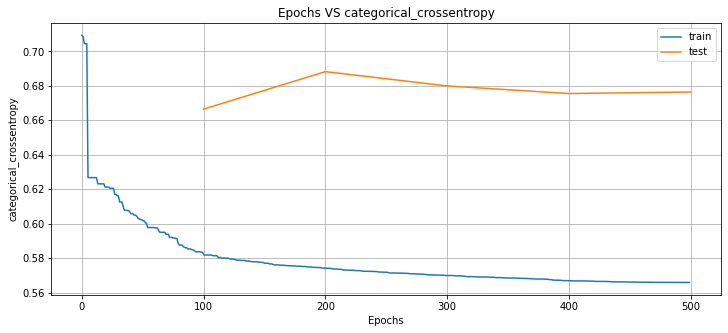

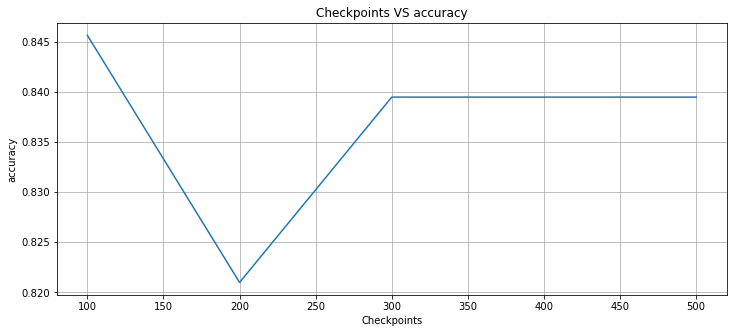

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 2.921909744244069, 'categorical_crossentropy': 0.6664767795138888, 'precision': 0.7685185185185185, 'recall': 0.7685185185185185, 'f1': 0.7685185185185186, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 5, 'fp_hit': 8, 'tn_hit': 83, 'fn_hit': 12}, 2: {'tp_hit': 6, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 9}}, 'checkpoint': 100} 


{'accuracy': 0.8209876543209876, 'mean_square_error': 2.94536134643276, 'categorical_crossentropy': 0.6882277594672309, 'precision': 0.7314814814814815, 'recall': 0.7314814814814815, 'f1': 0.7314814814814816, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 6}, 1: {'tp_hit': 6, 'fp_hit': 13, 'tn_hit': 78, 'fn_hit': 11}, 2: {'tp_hit': 3, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 12}}, 'checkpoint': 200} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.963253746220706, 'categorical_crossentropy': 0.6799250708685981, 'precision': 0.

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 1.5377781 ]
 [ 0.67076206]
 [ 2.2015815 ]
 [ 1.8903152 ]
 [-1.8022999 ]]
 bias: [1.7797198]

Neuron 1: weights:
[[ 0.5767559 ]
 [-1.6368521 ]
 [ 0.03819565]
 [ 0.38829625]
 [ 1.8864601 ]]
 bias: [2.1269178]

Neuron 2: weights:
[[-0.8340967]
 [ 2.9212713]
 [-1.226667 ]
 [-1.4894325]
 [ 1.9213188]]
 bias: [-3.]

Neuron 3: weights:
[[ 0.34129208]
 [ 2.5013058 ]
 [-0.5528743 ]
 [ 0.94117534]
 [-2.5905921 ]]
 bias: [-2.805762]

$
Layer 2
Neuron 0: weights:
[[-2.6296282]
 [ 0.2163057]
 [-3.       ]
 [-2.978507 ]]
 bias: [0.38609928]

Neuron 1: weights:
[[ 1.7325784]
 [-2.2281544]
 [ 1.5598007]
 [-1.9994314]]
 bias: [-2.5646021]

Neuron 2: weights:
[[ 0.08816203]
 [-1.8455391 ]
 [-0.14110455]
 [ 3.        ]]
 bias: [-2.1581402]

$

